# Google Colab setup with Google Drive folder

This notebook provides the code you need to set up Google Colab to run and import files from within a Google Drive folder.

This will allow you to upload assignment code to your Google Drive and then run the code on Google Colab machines (with free GPUs if needed).

You will need to create a folder in your Google Drive to hold your assignments and you will need to open Colaboratory within this folder before running the set up code (check the link above to see how).

# Mount Google Drive

This will allow the Colab machine to access Google Drive folders by mounting the drive on the machine. You will be asked to copy and paste an authentication code.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [2]:
ls

gdrive/  sample_data/


# Change directory to allow imports


As noted above, you should create a Google Drive folder to hold all your assignment files. You will need to add this code to the top of any python notebook you run to be able to import python files from your drive assignment folder (you should change the file path below to be your own assignment folder). Following the hand-out, you should have a directory "SFU_CMPT_CV_lab2" on g-drive, which should have a directory "data", which contains three tar.gz files.

In [3]:
import os
os.chdir("/content/gdrive/My Drive/SFU_CMPT_CV_lab2")

In [4]:
ls # Check if this is your folder

data/  lab2.ipynb  plot.png  R50x1_160.npz  submission_netid.csv


# Copy data to local dir

In [5]:
!mkdir /data
!cp data/cifar100.tar.gz /data/
!tar -xf /data/cifar100.tar.gz -C /data/
!cp data/test.tar.gz /data
!tar -xf /data/test.tar.gz -C /data
!cp data/train.tar.gz /data
!tar -xf /data/train.tar.gz -C /data/

mkdir: cannot create directory ‘/data’: File exists


In [6]:
ls /data

cifar100/  cifar100.tar.gz  test/  test.tar.gz  train/  train.tar.gz


# Set up GPU and PyTorch

First, ensure that your notebook on Colaboratory is set up to use GPU. After opening the notebook on Colaboratory, go to Edit>Notebook settings, select Python 3 under "Runtime type," select GPU under "Hardware accelerator," and save.

Next, install PyTorch:

In [7]:
!pip3 install torch torchvision

Make sure that pytorch is installed and works with GPU:

In [8]:
import torch
a = torch.Tensor([1]).cuda()
print(a)


tensor([1.], device='cuda:0')


In [9]:
torch.cuda.is_available()

True

# Part 1

In [15]:
"""Headers"""

from __future__ import print_function
from PIL import Image
import os
import os.path
import numpy as np
import sys
if sys.version_info[0] == 2:
    import cPickle as pickle
else:
    import pickle

import torch.utils.data as data
from torchvision.datasets.utils import download_url, check_integrity

import csv
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os.path
import sys
import torch
import torch.utils.data
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import ElasticTransform

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

np.random.seed(111)
torch.cuda.manual_seed_all(111)
torch.manual_seed(111)



## **Just execute the cell below. This is the dataloader. DO NOT CHANGE ANYTHING IN HERE!**


In [11]:
""""""

class CIFAR10_SFU_CV(data.Dataset):
    """`CIFAR10 <https://www.cs.toronto.edu/~kriz/cifar.html>`_ Dataset.

    Args:
        root (string): Root directory of dataset where directory
            ``cifar-10-batches-py`` exists or will be saved to if download is set to True.
        train (bool, optional): If True, creates dataset from training set, otherwise
            creates from test set.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
        download (bool, optional): If true, downloads the dataset from the internet and
            puts it in root directory. If dataset is already downloaded, it is not
            downloaded again.

    """
    base_folder = 'cifar100'
    url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
    filename = "cifar100.tar.gz"
    tgz_md5 = 'c58f30108f718f92721af3b95e74349a'
    train_list = [
        ['data_batch_1', 'c99cafc152244af753f735de768cd75f'],
        ['data_batch_2', 'd4bba439e000b95fd0a9bffe97cbabec'],
        ['data_batch_3', '54ebc095f3ab1f0389bbae665268c751'],
        ['data_batch_4', '634d18415352ddfa80567beed471001a'],
        ['data_batch_5', '482c414d41f54cd18b22e5b47cb7c3cb'],
    ]

    test_list = [
        ['test_batch', '40351d587109b95175f43aff81a1287e'],
    ]

    def __init__(self, root, fold="train",
                 transform=None, target_transform=None,
                 download=False):

        fold = fold.lower()

        self.train = False
        self.test = False
        self.val = False

        if fold == "train":
            self.train = True
        elif fold == "test":
            self.test = True
        elif fold == "val":
            self.val = True
        else:
            raise RuntimeError("Not train-val-test")


        self.root = os.path.expanduser(root)
        self.transform = transform
        self.target_transform = target_transform

        fpath = os.path.join(root, self.filename)
        if not self._check_integrity():
            raise RuntimeError('Dataset not found or corrupted.' +
                               ' Download it and extract the file again.')

        # now load the picked numpy arrays
        if self.train or self.val:
            self.train_data = []
            self.train_labels = []
            for fentry in self.train_list:
                f = fentry[0]
                file = os.path.join(self.root, self.base_folder, f)
                fo = open(file, 'rb')
                if sys.version_info[0] == 2:
                    entry = pickle.load(fo)
                else:
                    entry = pickle.load(fo, encoding='latin1')
                self.train_data.append(entry['data'])
                if 'labels' in entry:
                    self.train_labels += entry['labels']
                else:
                    self.train_labels += entry['fine_labels']
                fo.close()

            self.train_data = np.concatenate(self.train_data)
            self.train_data = self.train_data.reshape((50000, 3, 32, 32))
            self.train_data = self.train_data.transpose((0, 2, 3, 1))  # convert to HWC

            p = np.arange(0,50000,10)
            mask_train = np.ones((50000,), dtype=bool)
            mask_train[p] = False
            mask_val = np.zeros((50000,), dtype=bool)
            mask_val[p] = True

            copy_all_data = np.array(self.train_data)
            self.val_data = np.array(copy_all_data[mask_val])
            self.train_data = np.array(copy_all_data[mask_train])

            copy_all_labels = np.array(self.train_labels)
            self.val_labels = np.array(copy_all_labels[mask_val])
            self.train_labels = np.array(copy_all_labels[mask_train])

        elif self.test:
            f = self.test_list[0][0]
            file = os.path.join(self.root, self.base_folder, f)
            fo = open(file, 'rb')
            if sys.version_info[0] == 2:
                entry = pickle.load(fo)
            else:
                entry = pickle.load(fo, encoding='latin1')
            self.test_data = entry['data']

            if 'labels' in entry:
                self.test_labels = entry['labels']
            else:
                self.test_labels = entry['fine_labels']
            fo.close()
            self.test_data = self.test_data.reshape((10000, 3, 32, 32))
            self.test_data = self.test_data.transpose((0, 2, 3, 1))  # convert to HWC

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        if self.train:
            img, target = self.train_data[index], self.train_labels[index]
        elif self.test:
            img, target = self.test_data[index], self.test_labels[index]
        elif self.val:
            img, target = self.val_data[index], self.val_labels[index]

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img)

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self):
        if self.train:
            return len(self.train_data)
        elif self.test:
            return len(self.test_data)
        elif self.val:
            return len(self.val_data)

    def _check_integrity(self):
        root = self.root
        for fentry in (self.train_list + self.test_list):
            filename, md5 = fentry[0], fentry[1]
            fpath = os.path.join(root, self.base_folder, filename)
            if not check_integrity(fpath, md5):
                return False
        return True

    def __repr__(self):
        fmt_str = 'Dataset ' + self.__class__.__name__ + '\n'
        fmt_str += '    Number of datapoints: {}\n'.format(self.__len__())
        tmp = 'train' if self.train is True else 'test'
        fmt_str += '    Split: {}\n'.format(tmp)
        fmt_str += '    Root Location: {}\n'.format(self.root)
        tmp = '    Transforms (if any): '
        fmt_str += '{0}{1}\n'.format(tmp, self.transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        tmp = '    Target Transforms (if any): '
        fmt_str += '{0}{1}'.format(tmp, self.target_transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        return fmt_str


class CIFAR100_SFU_CV(CIFAR10_SFU_CV):
    """`CIFAR100 <https://www.cs.toronto.edu/~kriz/cifar.html>`_ Dataset.

    This is a subclass of the `CIFAR10` Dataset.
    """
    base_folder = 'cifar100'
    filename = "cifar100.tar.gz"
    tgz_md5 = 'e68a4c763591787a0b39fe2209371f32'
    train_list = [
        ['train_cs543', '49eee854445c1e2ebe796cd93c20bb0f'],
    ]

    test_list = [
        ['test_cs543', 'd3fe9f6a9251bd443f428f896d27384f'],
    ]

This file has been adapted from the easy-to-use tutorial released by PyTorch:
http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

Training an image classifier
----------------------------

We will do the following steps in order:

1. Load the CIFAR100_SFU_CV training, validation and test datasets using
   torchvision. Use torchvision.transforms to apply transforms on the
   dataset.
2. Define a Convolution Neural Network - BaseNet
3. Define a loss function and optimizer
4. Train the network on training data and check performance on val set.
   Plot train loss and validation accuracies.
5. Try the network on test data and create .csv file for submission to kaggle

## Hyper-parameters

In [12]:
# <<TODO#5>> Based on the val set performance, decide how many
# epochs are apt for your model.
# ---------
# EPOCHS = 50
# ---------

IS_GPU = True
TEST_BS = 64
TOTAL_CLASSES = 100
TRAIN_BS = 64
PATH_TO_CIFAR100_SFU_CV = "/data/"

In [13]:
ls /data/cifar100/

test_cs543  train_cs543


In [14]:
def calculate_val_accuracy(valloader, is_gpu):
    """ Util function to calculate val set accuracy,
    both overall and per class accuracy
    Args:
        valloader (torch.utils.data.DataLoader): val set
        is_gpu (bool): whether to run on GPU
    Returns:
        tuple: (overall accuracy, class level accuracy)
    """
    correct = 0.
    total = 0.
    # predictions = []

    class_correct = list(0. for i in range(TOTAL_CLASSES))
    class_total = list(0. for i in range(TOTAL_CLASSES))

    for data in valloader:
        images, labels = data
        if is_gpu:
            images = images.cuda()
            labels = labels.cuda()
        outputs = net(Variable(images))
        _, predicted = torch.max(outputs.data, 1)
        # predictions.extend(list(predicted.cpu().numpy()))
        total += labels.size(0)
        # The following line reported an error for some students. Put a new version.
        # correct += (predicted == labels).sum()
        correct += (predicted == labels).sum().item()

        # We need to move predicted and labels to CPU before using them with NumPy
        predicted = predicted.cpu()
        labels = labels.cpu()

        # The following line reported an error for some students. Put a new version.
        c = (predicted == labels).squeeze()
        # c = torch.squeeze(predicted == labels).detach().cpu().numpy()
        # Added for a
        #  fix.
        # c = c.cpu()

        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

    class_accuracy = 100 * np.divide(class_correct, class_total)
    return 100*correct/total, class_accuracy

1.** Loading CIFAR100_SFU_CV**

We modify the dataset to create CIFAR100_SFU_CV dataset which consist of 45000 training images (450 of each class), 5000 validation images (50 of each class) and 10000 test images (100 of each class). The train and val datasets have labels while all the labels in the test set are set to 0.


## Dataset

In [42]:
# The output of torchvision datasets are PILImage images of range [0, 1].
# Using transforms.ToTensor(), transform them to Tensors of normalized range
# [-1, 1].


# <<TODO#1>> Use transforms.Normalize() with the right parameters to
# make the data well conditioned (zero mean, std dev=1) for improved training.
# <<TODO#2>> Try using transforms.RandomCrop() and/or transforms.RandomHorizontalFlip()
# to augment training data.
# After your edits, make sure that test_transform should have the same data
# normalization parameters as train_transform
# You shouldn't have any data augmentation in test_transform (val or test data is never augmented).
# ---------------------

train_transform = transforms.Compose(
    [
        transforms.Resize(160),
        transforms.RandomCrop(128),
        # transforms.RandomCrop(size=32, padding=4),                # Random cropping with padding
        # transforms.RandomHorizontalFlip(),                        # Random horizontal flip
        # transforms.RandomVerticalFlip(),                          # Random vertical flip
        # transforms.RandomRotation(20),                           # Random rotation up to 10 degrees
        # transforms.ColorJitter(brightness=0.2, contrast=0.2),     # Random gamma correction for brightness
        # transforms.Grayscale(num_output_channels=3),              # Convert to grayscale
        transforms.ToTensor(),                                    # Convert image to tensor
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))    # Normalize to [-1, 1] range
    ]
)
test_transform = transforms.Compose(
    [
    transforms.Resize(128),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# ---------------------

trainset = CIFAR100_SFU_CV(root=PATH_TO_CIFAR100_SFU_CV, fold="train",
                                        download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=TRAIN_BS,
                                          shuffle=True, num_workers=0)
print("Train set size: "+str(len(trainset)))

valset = CIFAR100_SFU_CV(root=PATH_TO_CIFAR100_SFU_CV, fold="val",
                                       download=True, transform=test_transform)
valloader = torch.utils.data.DataLoader(valset, batch_size=TEST_BS,
                                         shuffle=False, num_workers=0)
print("Val set size: "+str(len(valset)))

testset = CIFAR100_SFU_CV(root=PATH_TO_CIFAR100_SFU_CV, fold="test",
                                       download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=TEST_BS,
                                         shuffle=False, num_workers=0)
print("Test set size: "+str(len(testset)))

# The 100 classes for CIFAR100
classes = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']



Train set size: 45000
Val set size: 5000
Test set size: 10000


## Models

### VGG-19 Design

best model

best score 61% on 32x32 images

77% on 128x128 images

refer to https://www.geeksforgeeks.org/vgg-net-architecture-explained/

In [32]:
########################################################################
# 2. Define a Convolution Neural Network
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# We provide a basic network that you should understand, run and
# eventually improve
# <<TODO>> Add more conv layers
# <<TODO>> Add more fully connected (fc) layers
# <<TODO>> Add regularization layers like Batchnorm.
#          nn.BatchNorm2d after conv layers:
#          http://pytorch.org/docs/master/nn.html#batchnorm2d
#          nn.BatchNorm1d after fc layers:
#          http://pytorch.org/docs/master/nn.html#batchnorm1d
# This is a good resource for developing a CNN for classification:
# http://cs231n.github.io/convolutional-networks/#layers

import torch.nn as nn
import torch.nn.functional as F

class BaseNet(nn.Module):
    def __init__(self):
        super(BaseNet, self).__init__()

        # <<TODO#3>> Add more conv layers with increasing
        # output channels
        # <<TODO#4>> Add normalization layers after conv
        # layers (nn.BatchNorm2d)

        # Also experiment with kernel size in conv2d layers (say 3
        # inspired from VGGNet)
        # To keep it simple, keep the same kernel size
        # (right now set to 5) in all conv layers.
        # Do not have a maxpool layer after every conv layer in your
        # deeper network as it leads to too much loss of information.

        # First Convolution Block (2 layers)
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1_1 = nn.BatchNorm2d(64)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn1_2 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # assume our input is 32x32, Output: 16x16

        # Second Convolution Block (2 layers)
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2_1 = nn.BatchNorm2d(128)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn2_2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: 8x8

        # Third Convolution Block (4 layers)
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3_1 = nn.BatchNorm2d(256)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn3_2 = nn.BatchNorm2d(256)
        # self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        # self.bn3_3 = nn.BatchNorm2d(256)
        # self.conv3_4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        # self.bn3_4 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: 4x4

        # Fourth Convolution Block (4 layers)
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4_1 = nn.BatchNorm2d(512)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn4_2 = nn.BatchNorm2d(512)
        # self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        # self.bn4_3 = nn.BatchNorm2d(512)
        # self.conv4_4 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        # self.bn4_4 = nn.BatchNorm2d(512)
        # self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: 2x2

        # Fifth Convolution Block (4 layers)
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn5_1 = nn.BatchNorm2d(512)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn5_2 = nn.BatchNorm2d(512)
        # self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        # self.bn5_3 = nn.BatchNorm2d(512)
        # self.conv5_4 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        # self.bn5_4 = nn.BatchNorm2d(512)
        # self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: 1x1
        self.pool5 = nn.AdaptiveAvgPool2d((1,1))

        # <<TODO#3>> Add more linear (fc) layers
        # <<TODO#4>> Add normalization layers after linear and
        # experiment inserting them before or after ReLU (nn.BatchNorm1d)
        # More on nn.sequential:
        # http://pytorch.org/docs/master/nn.html#torch.nn.Sequential

        self.fc_net = nn.Sequential(
            # nn.Dropout(0.2),
            nn.Linear(512, 4096),
            # nn.BatchNorm1d(4096),
            nn.ReLU(inplace=True),
            # nn.Dropout(0.2),
            # nn.Linear(4096, 4096),
            # nn.BatchNorm1d(4096),
            # nn.ReLU(inplace=True),
            # nn.Dropout(0.2),
            nn.Linear(4096, TOTAL_CLASSES)
        )

    def forward(self, x):

        # <<TODO#3&#4>> Based on the above edits, you'll have
        # to edit the forward pass description here.

        # First block
        x = F.relu(self.bn1_1(self.conv1_1(x)))
        x = F.relu(self.bn1_2(self.conv1_2(x)))
        x = self.pool1(x)

        # Second block
        x = F.relu(self.bn2_1(self.conv2_1(x)))
        x = F.relu(self.bn2_2(self.conv2_2(x)))
        x = self.pool2(x)

        # Third block
        x = F.relu(self.bn3_1(self.conv3_1(x)))
        x = F.relu(self.bn3_2(self.conv3_2(x)))
        # x = F.relu(self.bn3_3(self.conv3_3(x)))
        # x = F.relu(self.bn3_4(self.conv3_4(x)))
        x = self.pool3(x)

        # Fourth block
        x = F.relu(self.bn4_1(self.conv4_1(x)))
        x = F.relu(self.bn4_2(self.conv4_2(x)))
        # x = F.relu(self.bn4_3(self.conv4_3(x)))
        # x = F.relu(self.bn4_4(self.conv4_4(x)))
        # x = self.pool4(x)

        # Fifth block
        x = F.relu(self.bn5_1(self.conv5_1(x)))
        x = F.relu(self.bn5_2(self.conv5_2(x)))
        # x = F.relu(self.bn5_3(self.conv5_3(x)))
        # x = F.relu(self.bn5_4(self.conv5_4(x)))
        x = self.pool5(x)

        # See the CS231 link to understand why this is 16*5*5!
        # This will help you design your own deeper network
        x = x.view(x.size(0), -1)
        x = self.fc_net(x)

        # No softmax is needed as the loss function in step 3
        # takes care of that

        return x

# Create an instance of the nn.module class defined above:
net = BaseNet()

# For training on GPU, we need to transfer net and data onto the GPU
# http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-on-gpu
if IS_GPU:
    net = net.cuda()


### VGG-19 + ResNet-18 Design

best score 58% on 32x32 images

67% on 128x128 images


In [79]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VGG19ResNetHybrid(nn.Module):
    def __init__(self):
        super(VGG19ResNetHybrid, self).__init__()

        # First Convolution Block (2 layers)
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1_1 = nn.BatchNorm2d(64)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn1_2 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: 16x16

        # Second Convolution Block (2 layers)
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2_1 = nn.BatchNorm2d(128)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn2_2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: 8x8

        # Third Convolution Block (4 layers)
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3_1 = nn.BatchNorm2d(256)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn3_2 = nn.BatchNorm2d(256)
        # self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        # self.bn3_3 = nn.BatchNorm2d(256)
        # self.conv3_4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        # self.bn3_4 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: 4x4

        # Fourth Convolution Block (4 layers)
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4_1 = nn.BatchNorm2d(512)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn4_2 = nn.BatchNorm2d(512)
        # self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        # self.bn4_3 = nn.BatchNorm2d(512)
        # self.conv4_4 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        # self.bn4_4 = nn.BatchNorm2d(512)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: 2x2

        # Fifth Convolution Block (4 layers)
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn5_1 = nn.BatchNorm2d(512)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn5_2 = nn.BatchNorm2d(512)
        # self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        # self.bn5_3 = nn.BatchNorm2d(512)
        # self.conv5_4 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        # self.bn5_4 = nn.BatchNorm2d(512)
        # self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: 1x1
        self.pool5 = nn.AdaptiveAvgPool2d((1,1))

        # Skip connections from earlier blocks
        self.skip_connect1 = nn.Conv2d(64, 128, kernel_size=1, stride=2)  # Skip from 1st to 2nd
        self.skip_connect2 = nn.Conv2d(128, 256, kernel_size=1, stride=2)  # Skip from 2nd to 3rd
        self.skip_connect3 = nn.Conv2d(256, 512, kernel_size=1, stride=2)  # Skip from 3rd to 4th

        # Fully connected layers
        self.fc_net = nn.Sequential(
            nn.Linear(512, 4096),  # Adjusted for 1x1 input
            nn.ReLU(inplace=True),
            nn.Linear(4096, TOTAL_CLASSES)
        )

    def forward(self, x):
        # First block
        x1 = F.relu(self.bn1_1(self.conv1_1(x)))
        x1 = F.relu(self.bn1_2(self.conv1_2(x1)))
        x1_pooled = self.pool1(x1)

        # Second block with skip connection from the first block
        x2 = F.relu(self.bn2_1(self.conv2_1(x1_pooled)))
        x2 = F.relu(self.bn2_2(self.conv2_2(x2)))
        skip1 = self.skip_connect1(x1)  # Adjust dimensions for skip connection
        x2_pooled = self.pool2(x2 + skip1)

        # Third block with skip connection from the second block
        x3 = F.relu(self.bn3_1(self.conv3_1(x2_pooled)))
        x3 = F.relu(self.bn3_2(self.conv3_2(x3)))
        skip2 = self.skip_connect2(x2)  # Adjust dimensions for skip connection
        x3_pooled = self.pool3(x3 + skip2)

        # Fourth block with skip connection from the third block
        x4 = F.relu(self.bn4_1(self.conv4_1(x3_pooled)))
        x4 = F.relu(self.bn4_2(self.conv4_2(x4)))
        skip3 = self.skip_connect3(x3)  # Adjust dimensions for skip connection
        x4_pooled = self.pool4(x4 + skip3)

        # Fifth block (no skip connection here)
        x5 = F.relu(self.bn5_1(self.conv5_1(x4_pooled)))
        x5 = F.relu(self.bn5_2(self.conv5_2(x5)))
        x5_pooled = self.pool5(x5)

        # Flatten and pass through fully connected layers
        x_flat = x5_pooled.view(x5_pooled.size(0), -1)
        x_out = self.fc_net(x_flat)

        return x_out


class VGG19ResNetHybridConcat(nn.Module):
    def __init__(self):
        super(VGG19ResNetHybridConcat, self).__init__()

        # First Convolution Block (2 layers)
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1_1 = nn.BatchNorm2d(64)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn1_2 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: 16x16

        # Second Convolution Block (2 layers)
        self.conv2_1 = nn.Conv2d(128, 128, kernel_size=3, padding=1)  # Adjusted for concatenated input
        self.bn2_1 = nn.BatchNorm2d(128)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn2_2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: 8x8

        # Third Convolution Block (2 layers)
        self.conv3_1 = nn.Conv2d(256, 256, kernel_size=3, padding=1)  # Adjusted for concatenated input
        self.bn3_1 = nn.BatchNorm2d(256)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn3_2 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: 4x4

        # Fourth Convolution Block (2 layers)
        self.conv4_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)  # Adjusted for concatenated input
        self.bn4_1 = nn.BatchNorm2d(512)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn4_2 = nn.BatchNorm2d(512)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: 2x2

        # Fifth Convolution Block (2 layers)
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn5_1 = nn.BatchNorm2d(512)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn5_2 = nn.BatchNorm2d(512)
        self.pool5 = nn.AdaptiveAvgPool2d((1, 1))

        # Skip connections using concatenation from earlier blocks
        self.skip_connect1 = nn.Conv2d(64, 64, kernel_size=1, stride=2)  # Skip from 1st to 2nd
        self.skip_connect2 = nn.Conv2d(128, 128, kernel_size=1, stride=2)  # Skip from 2nd to 3rd
        self.skip_connect3 = nn.Conv2d(256, 256, kernel_size=1, stride=2)  # Skip from 3rd to 4th

        # Fully connected layers
        self.fc_net = nn.Sequential(
            nn.Linear(512, 4096),  # Adjusted for 1x1 input
            nn.ReLU(inplace=True),
            nn.Linear(4096, TOTAL_CLASSES)
        )

    def forward(self, x):
        # First block
        x1 = F.relu(self.bn1_1(self.conv1_1(x)))
        x1 = F.relu(self.bn1_2(self.conv1_2(x1)))
        x1_pooled = self.pool1(x1)

        # Second block with concatenation from the first block
        skip1 = self.skip_connect1(x1)  # Adjust dimensions for skip connection
        x2 = F.relu(self.bn2_1(self.conv2_1(torch.cat((x1_pooled, skip1), dim=1))))
        x2 = F.relu(self.bn2_2(self.conv2_2(x2)))
        x2_pooled = self.pool2(x2)

        # Third block with concatenation from the second block
        skip2 = self.skip_connect2(x2)  # Adjust dimensions for skip connection
        x3 = F.relu(self.bn3_1(self.conv3_1(torch.cat((x2_pooled, skip2), dim=1))))
        x3 = F.relu(self.bn3_2(self.conv3_2(x3)))
        x3_pooled = self.pool3(x3)

        # Fourth block with concatenation from the third block
        skip3 = self.skip_connect3(x3)  # Adjust dimensions for skip connection
        x4 = F.relu(self.bn4_1(self.conv4_1(torch.cat((x3_pooled, skip3), dim=1))))
        x4 = F.relu(self.bn4_2(self.conv4_2(x4)))
        x4_pooled = self.pool4(x4)

        # Fifth block (no skip connection here)
        x5 = F.relu(self.bn5_1(self.conv5_1(x4_pooled)))
        x5 = F.relu(self.bn5_2(self.conv5_2(x5)))
        x5_pooled = self.pool5(x5)

        # Flatten and pass through fully connected layers
        x_flat = x5_pooled.view(x5_pooled.size(0), -1)
        x_out = self.fc_net(x_flat)

        return x_out


# Create an instance of the nn.module class defined above:
# net = VGG19ResNetHybrid()
net = VGG19ResNetHybridConcat()

# For training on GPU, we need to transfer net and data onto the GPU
# http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-on-gpu
if IS_GPU:
    net = net.cuda()


### GoogleNet Design

best score 58% on 32x32 images

62% on 128x128 images

In [16]:
import torch.nn as nn

class Inception(nn.Module):
    def __init__(self, input_channels, n1x1, n3x3_reduce, n3x3, n5x5_reduce, n5x5, pool_proj):
        super(Inception, self).__init__()

        self.b1 = nn.Sequential(
            nn.Conv2d(input_channels, n1x1, kernel_size=1),
            nn.BatchNorm2d(n1x1),
            nn.ReLU(inplace=True)
        )

        self.b2 = nn.Sequential(
            nn.Conv2d(input_channels, n3x3_reduce, kernel_size=1),
            nn.BatchNorm2d(n3x3_reduce),
            nn.ReLU(inplace=True),
            nn.Conv2d(n3x3_reduce, n3x3, kernel_size=3, padding=1),
            nn.BatchNorm2d(n3x3),
            nn.ReLU(inplace=True)
        )

        self.b3 = nn.Sequential(
            nn.Conv2d(input_channels, n5x5_reduce, kernel_size=1),
            nn.BatchNorm2d(n5x5_reduce),
            nn.ReLU(inplace=True),
            nn.Conv2d(n5x5_reduce, n5x5, kernel_size=3, padding=1),
            nn.BatchNorm2d(n5x5),
            nn.ReLU(inplace=True),
            nn.Conv2d(n5x5, n5x5, kernel_size=3, padding=1),
            nn.BatchNorm2d(n5x5),
            nn.ReLU(inplace=True)
        )

        self.b4 = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1),
            nn.Conv2d(input_channels, pool_proj, kernel_size=1),
            nn.BatchNorm2d(pool_proj),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return torch.cat([self.b1(x), self.b2(x), self.b3(x), self.b4(x)], dim=1)


class GoogleNet(nn.Module):
    def __init__(self, num_class=100):
        super(GoogleNet, self).__init__()
        self.prelayer = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 192, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
        )

        self.a3 = Inception(192, 64, 96, 128, 16, 32, 32)
        self.b3 = Inception(256, 128, 128, 192, 32, 96, 64)

        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1)

        self.a4 = Inception(480, 192, 96, 208, 16, 48, 64)
        self.b4 = Inception(512, 160, 112, 224, 24, 64, 64)
        self.c4 = Inception(512, 128, 128, 256, 24, 64, 64)
        self.d4 = Inception(512, 112, 144, 288, 32, 64, 64)
        self.e4 = Inception(528, 256, 160, 320, 32, 128, 128)

        self.a5 = Inception(832, 256, 160, 320, 32, 128, 128)
        self.b5 = Inception(832, 384, 192, 384, 48, 128, 128)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout2d(p=0.4)
        self.linear = nn.Linear(1024, num_class)

    def forward(self, x):
        x = self.prelayer(x)
        x = self.maxpool(x)
        x = self.a3(x)
        x = self.b3(x)
        x = self.maxpool(x)
        x = self.a4(x)
        x = self.b4(x)
        x = self.c4(x)
        x = self.d4(x)
        x = self.e4(x)
        x = self.maxpool(x)
        x = self.a5(x)
        x = self.b5(x)
        x = self.avgpool(x)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x

# Create an instance of the nn.module class defined above:
net = GoogleNet(num_class=TOTAL_CLASSES)

# For training on GPU, we need to transfer net and data onto the GPU
# http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-on-gpu
if IS_GPU:
    net = net.cuda()

### BiT-M-R50x1 (ResNetV2) Design

best score 38% without model arachitecture modification on 32x32 images

62% on 128x128 images

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from collections import OrderedDict


class StdConv2d(nn.Conv2d):

  def forward(self, x):
    w = self.weight
    v, m = torch.var_mean(w, dim=[1, 2, 3], keepdim=True, unbiased=False)
    w = (w - m) / torch.sqrt(v + 1e-10)
    return F.conv2d(x, w, self.bias, self.stride, self.padding,
                    self.dilation, self.groups)


def conv3x3(cin, cout, stride=1, groups=1, bias=False):
  return StdConv2d(cin, cout, kernel_size=3, stride=stride,
                   padding=1, bias=bias, groups=groups)


def conv1x1(cin, cout, stride=1, bias=False):
  return StdConv2d(cin, cout, kernel_size=1, stride=stride,
                   padding=0, bias=bias)


def tf2th(conv_weights):
  """Possibly convert HWIO to OIHW."""
  if conv_weights.ndim == 4:
    conv_weights = conv_weights.transpose([3, 2, 0, 1])
  return torch.from_numpy(conv_weights)


class PreActBottleneck(nn.Module):
  """Pre-activation (v2) bottleneck block.

  Follows the implementation of "Identity Mappings in Deep Residual Networks":
  https://github.com/KaimingHe/resnet-1k-layers/blob/master/resnet-pre-act.lua

  Except it puts the stride on 3x3 conv when available.
  """

  def __init__(self, cin, cout=None, cmid=None, stride=1):
    super().__init__()
    cout = cout or cin
    cmid = cmid or cout//4

    self.gn1 = nn.GroupNorm(32, cin)
    self.conv1 = conv1x1(cin, cmid)
    self.gn2 = nn.GroupNorm(32, cmid)
    self.conv2 = conv3x3(cmid, cmid, stride)  # Original code has it on conv1!!
    self.gn3 = nn.GroupNorm(32, cmid)
    self.conv3 = conv1x1(cmid, cout)
    self.relu = nn.ReLU(inplace=True)

    if (stride != 1 or cin != cout):
      # Projection also with pre-activation according to paper.
      self.downsample = conv1x1(cin, cout, stride)

  def forward(self, x):
    out = self.relu(self.gn1(x))

    # Residual branch
    residual = x
    if hasattr(self, 'downsample'):
      residual = self.downsample(out)

    # Unit's branch
    out = self.conv1(out)
    out = self.conv2(self.relu(self.gn2(out)))
    out = self.conv3(self.relu(self.gn3(out)))

    return out + residual

class ResNetV2(nn.Module):
  """Implementation of Pre-activation (v2) ResNet mode."""

  def __init__(self, block_units, width_factor, head_size=21843, zero_head=False):
    super().__init__()
    wf = width_factor  # shortcut 'cause we'll use it a lot.

    # The following will be unreadable if we split lines.
    # pylint: disable=line-too-long
    self.root = nn.Sequential(OrderedDict([
        ('conv', StdConv2d(3, 64*wf, kernel_size=7, stride=2, padding=3, bias=False)),
        ('pad', nn.ConstantPad2d(1, 0)),
        ('pool', nn.MaxPool2d(kernel_size=3, stride=2, padding=0)),
        # The following is subtly not the same!
        # ('pool', nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
    ]))

    self.body = nn.Sequential(OrderedDict([
        ('block1', nn.Sequential(OrderedDict(
            [('unit01', PreActBottleneck(cin=64*wf, cout=256*wf, cmid=64*wf))] +
            [(f'unit{i:02d}', PreActBottleneck(cin=256*wf, cout=256*wf, cmid=64*wf)) for i in range(2, block_units[0] + 1)],
        ))),
        ('block2', nn.Sequential(OrderedDict(
            [('unit01', PreActBottleneck(cin=256*wf, cout=512*wf, cmid=128*wf, stride=2))] +
            [(f'unit{i:02d}', PreActBottleneck(cin=512*wf, cout=512*wf, cmid=128*wf)) for i in range(2, block_units[1] + 1)],
        ))),
        ('block3', nn.Sequential(OrderedDict(
            [('unit01', PreActBottleneck(cin=512*wf, cout=1024*wf, cmid=256*wf, stride=2))] +
            [(f'unit{i:02d}', PreActBottleneck(cin=1024*wf, cout=1024*wf, cmid=256*wf)) for i in range(2, block_units[2] + 1)],
        ))),
        ('block4', nn.Sequential(OrderedDict(
            [('unit01', PreActBottleneck(cin=1024*wf, cout=2048*wf, cmid=512*wf, stride=2))] +
            [(f'unit{i:02d}', PreActBottleneck(cin=2048*wf, cout=2048*wf, cmid=512*wf)) for i in range(2, block_units[3] + 1)],
        ))),
    ]))
    # pylint: enable=line-too-long

    self.zero_head = zero_head
    self.head = nn.Sequential(OrderedDict([
            ('gn', nn.GroupNorm(32, 2048 * width_factor)),
            ('relu', nn.ReLU(inplace=True)),
            ('avg', nn.AdaptiveAvgPool2d(output_size=1)),
            ('conv', nn.Conv2d(2048 * width_factor, head_size, kernel_size=1, bias=True)),  # Adjusted for 100 classes
        ]))

  def forward(self, x):
    x = self.head(self.body(self.root(x)))
    assert x.shape[-2:] == (1, 1)  # We should have no spatial shape left.
    return x[...,0,0]


# Create an instance of the nn.module class defined above:
net = ResNetV2([3, 4, 6, 3], 1, head_size=TOTAL_CLASSES)  # BiT-M-R50x1 with CIFAR-100 classes

# For training on GPU, we need to transfer net and data onto the GPU
# http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-on-gpu
if IS_GPU:
    net = net.cuda()

In [55]:
########################################################################
# 3. Define a Loss function and optimizer
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# Here we use Cross-Entropy loss and SGD with momentum.
# The CrossEntropyLoss criterion already includes softmax within its
# implementation. That's why we don't use a softmax in our model
# definition.

import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Tune the learning rate.
# See whether the momentum is useful or not
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
# optimizer = optim.Adam(net.parameters(), lr=0.01)

scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=2)

plt.ioff()
fig = plt.figure()
train_loss_over_epochs = []
val_accuracy_over_epochs = []



## Model training


In [ ]:
########################################################################
# 4. Train the network
# ^^^^^^^^^^^^^^^^^^^^
#
# We simply have to loop over our data iterator, and feed the inputs to the
# network and optimize. We evaluate the validation accuracy at each
# epoch and plot these values over the number of epochs
# Nothing to change here
# -----------------------------

EPOCHS = 100

for epoch in range(EPOCHS):  # loop over the dataset multiple times

    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        if IS_GPU:
            inputs = inputs.cuda()
            labels = labels.cuda()

        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)  # Get the index of the max log-probability
        total_train += labels.size(0)  # Update total number of examples
        correct_train += (predicted == labels).sum().item()  # Update correct predictions

    # Normalizing the loss by the total number of train batches
    running_loss/=len(trainloader)

    # Calculate training accuracy for the epoch
    train_accuracy = 100 * correct_train / total_train

    # Scale of 0.0 to 100.0
    # Calculate validation set accuracy of the existing model
    val_accuracy, val_classwise_accuracy = \
        calculate_val_accuracy(valloader, IS_GPU)

    # # Optionally print classwise accuracies
    # for c_i in range(TOTAL_CLASSES):
    #     print('Accuracy of %5s : %2d %%' % (
    #         classes[c_i], 100 * val_classwise_accuracy[c_i]))

    # Step the scheduler at the end of each epoch
    scheduler.step(int(val_accuracy))

    print('[epoch %d] train loss: %.3f, train accuracy: %d %%, val accuracy: %d %%, learning rate: %s' %
      (epoch + 1, running_loss, train_accuracy, val_accuracy, scheduler.get_last_lr()))

    train_loss_over_epochs.append(running_loss)
    val_accuracy_over_epochs.append(val_accuracy)
# -----------------------------

In [ ]:
# Plot train loss over epochs and val set accuracy over epochs
# Nothing to change here
# -------------
plt.subplot(2, 1, 1)
plt.ylabel('Train loss')
plt.plot(np.arange(EPOCHS), train_loss_over_epochs, 'k-')
plt.title('train loss and val accuracy')
plt.xticks(np.arange(EPOCHS, dtype=int))
plt.grid(True)

plt.subplot(2, 1, 2)
# The line added for a bug fix.
# val_accuracy_over_epochs = torch.tensor(val_accuracy_over_epochs, device = 'cpu')

plt.plot(np.arange(EPOCHS), val_accuracy_over_epochs, 'b-')
plt.ylabel('Val accuracy')
plt.xlabel('Epochs')
plt.xticks(np.arange(EPOCHS, dtype=int))
plt.grid(True)
plt.savefig("plot.png")
plt.close(fig)
print('Finished Training')
# -------------

In [58]:
########################################################################
# 5. Try the network on test data, and create .csv file
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
########################################################################

# Check out why .eval() is important!
# https://discuss.pytorch.org/t/model-train-and-model-eval-vs-model-and-model-eval/5744/2
net.eval()

total = 0
predictions = []
for data in testloader:
    images, labels = data

    # For training on GPU, we need to transfer net and data onto the GPU
    # http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-on-gpu
    if IS_GPU:
        images = images.cuda()
        labels = labels.cuda()

    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    predictions.extend(list(predicted.cpu().numpy()))
    total += labels.size(0)

with open('submission_netid.csv', 'w') as csvfile:
    wr = csv.writer(csvfile, quoting=csv.QUOTE_ALL)
    wr.writerow(["Id", "Prediction1"])
    for l_i, label in enumerate(predictions):
        wr.writerow([str(l_i), str(label)])


# Part 2

In [12]:
"""Headers"""
import os
import os.path as osp
import time

%matplotlib inline
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim

from torchvision import datasets

# Pre-Trained Model

TODO1. Load pretrained resnet model. Experiment with different models.

TODO2: Replace last fc layer

TODO3. Forward pass

In [42]:
class PreTrainedResNet(nn.Module):
  def __init__(self, num_classes, feature_extracting):
    super(PreTrainedResNet, self).__init__()

    #TODO1: Load pre-trained ResNet Model
    self.resnet50 = models.resnet50(pretrained=True)

    #Set gradients to false
    if feature_extracting:
      for param in self.resnet50.parameters():
          param.requires_grad = False

    #Replace last fc layer
    num_feats = self.resnet50.fc.in_features

    #TODO2: Replace fc layer in resnet to a linear layer of size (num_feats, num_classes)
    self.resnet50.fc = nn.Linear(num_feats, num_classes)
  def forward(self, x):
    #TODO3: Forward pass x through the model
    x = self.resnet50(x)
    return x

# Train

In [30]:
def train(model, optimizer, criterion, epoch, num_epochs):
  model.train()
  epoch_loss = 0.0
  epoch_acc = 0.0

  for batch_idx, (images, labels) in enumerate(dataloaders['train']):
    #zero the parameter gradients
    optimizer.zero_grad()

    #move to GPU
    images, labels = images.cuda(), labels.cuda()

    #forward
    outputs = model.forward(images)

    loss = criterion(outputs, labels)

    _, preds = torch.max(outputs.data, 1)

    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()
    epoch_acc += torch.sum(preds == labels).item()

  epoch_loss /= dataset_sizes['train']
  epoch_acc /= dataset_sizes['train']

  print('TRAINING Epoch %d/%d Loss %.4f Accuracy %.4f' % (epoch, num_epochs, epoch_loss, epoch_acc))

# Main

1. Vary hyperparams
2. Data augmentation

In [51]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

#TODO: Vary Hyperparams

NUM_EPOCHS = 12
LEARNING_RATE = 0.01
BATCH_SIZE = 128
RESNET_LAST_ONLY = False #Fine tunes only the last layer. Set to False to fine tune entire network

plt.ioff()
fig = plt.figure()
train_loss_over_epochs = []
val_accuracy_over_epochs = []

root_path = '/data/' #If your data is in a different folder, set the path accodordingly

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        #TODO: Transforms.RandomResizedCrop() instead of CenterCrop(), RandomRoate() and Horizontal Flip()
        # transforms.RandomResizedCrop(256),
        transforms.RandomHorizontalFlip(),
        # transforms.RandomVerticalFlip(),
        transforms.RandomRotation(20),
        # transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        #TODO: Transforms.Normalize()
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        #TODO: Transforms.Normalize()
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),
}

# loading datasets with PyTorch ImageFolder
image_datasets = {x: datasets.ImageFolder(os.path.join(root_path, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}

# defining data loaders to load data using image_datasets and transforms, here we also specify batch size for the mini batch
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

#Initialize the model
model = PreTrainedResNet(len(class_names), RESNET_LAST_ONLY)
model = model.cuda()

#Setting the optimizer and loss criterion
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)
criterion = nn.CrossEntropyLoss()

#Begin Train
for epoch in range(NUM_EPOCHS):
  train(model, optimizer, criterion, epoch+1, NUM_EPOCHS)

print("Finished Training")
print("-"*10)

TRAINING Epoch 1/25 Loss 0.0417 Accuracy 0.0260
TRAINING Epoch 2/25 Loss 0.0326 Accuracy 0.2517
TRAINING Epoch 3/25 Loss 0.0226 Accuracy 0.4780
TRAINING Epoch 4/25 Loss 0.0153 Accuracy 0.6423
TRAINING Epoch 5/25 Loss 0.0104 Accuracy 0.7820
TRAINING Epoch 6/25 Loss 0.0072 Accuracy 0.8617
TRAINING Epoch 7/25 Loss 0.0049 Accuracy 0.9177
TRAINING Epoch 8/25 Loss 0.0035 Accuracy 0.9543
TRAINING Epoch 9/25 Loss 0.0024 Accuracy 0.9713
TRAINING Epoch 10/25 Loss 0.0017 Accuracy 0.9853
TRAINING Epoch 11/25 Loss 0.0014 Accuracy 0.9890
TRAINING Epoch 12/25 Loss 0.0010 Accuracy 0.9937


KeyboardInterrupt: 

# Test

In [52]:
def test(model, criterion, repeats=2):
  model.eval()

  test_loss = 0.0
  test_acc = 0.0

  with torch.no_grad():
    for itr in range(repeats):
      for batch_idx, (images, labels) in enumerate(dataloaders['test']):
        #move to GPU
        images, labels = images.cuda(), labels.cuda()

        #forward
        outputs = model.forward(images)

        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs.data, 1)

        test_loss += loss.item()
        test_acc += torch.sum(preds == labels).item()

    test_loss /= (dataset_sizes['test']*repeats)
    test_acc /= (dataset_sizes['test']*repeats)

    print('Test Loss: %.4f Test Accuracy %.4f' % (test_loss, test_acc))


test(model, criterion)

Test Loss: 0.0110 Test Accuracy 0.6413


# Visualizing the model predictions

Only for viusalizing. Nothing to be done here.

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

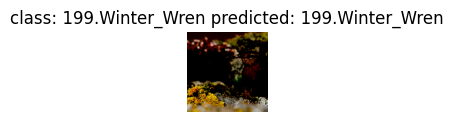

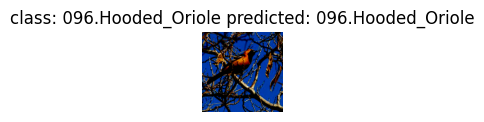

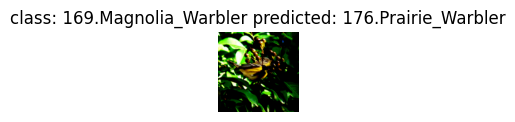

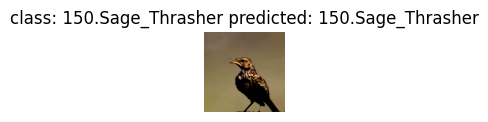

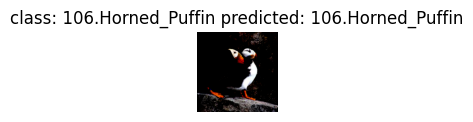

KeyboardInterrupt: 

In [53]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(1)  # pause a bit so that plots are updated

def visualize_model(model, num_images=8):
    images_so_far = 0
    fig = plt.figure()

    for batch_idx, (images, labels) in enumerate(dataloaders['test']):
        #move to GPU
        images, labels = images.cuda(), labels.cuda()

        outputs = model(images)

        _, preds = torch.max(outputs.data, 1)


        for j in range(images.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('class: {} predicted: {}'.format(class_names[labels.data[j]], class_names[preds[j]]))

            imshow(images.cpu().data[j])

            if images_so_far == num_images:
                return

visualize_model(model)